In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Image Retrieval'
!ls

/content/drive/MyDrive/Image Retrieval
 augmentation.ipynb		   subclass_scenario
 binary_scenario		   train_auto_encoder_magnification_1_200.ipynb
 binary_scenario_augmented_400X    train_auto_encoder_magnification_1_400.ipynb
 checkpoint			   train_auto_encoder_subclass_1_200.ipynb
 citra_split.ipynb		   train_auto_encoder_subclass_1_400.ipynb
 core				   training_1_200
'data test splitting.ipynb'	   training_1_200.h5
 extract_feature_binary.ipynb	   training_1_200.json
 extract_feature_subclass.ipynb    training_1_400
 index_images.ipynb		   training_1_400.json
 original			   training_1_400_subclass
 paper				   training_1_400_subclass.h5
 reconstruction			   training_1.h5
 retrieval_1_200X.ipynb		   training_1_indexed_200.json
 retrieval_1_400X.ipynb		   training_1_indexed_400.json
 retrieval_1_400X_subclass.ipynb   training_1_indexed_400_subclass.json
 retrieval.ipynb		   training_1.json
 subclass_400


In [ ]:
import matplotlib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
class ConvAutoEncoder:
    @staticmethod
    def build(width, height, depth, filters=(128,), latent_dim=48):
        input_shape = (height, width, depth)
        channel_dim = -1
        inputs = Input(shape=input_shape)
        x = inputs
        # Encoder layer
        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=channel_dim, name='enc_filter_'+str(f))(x)

        volume_size = K.int_shape(x)
        x = Flatten()(x)
        # Latent layer
        latent = Dense(latent_dim, name="encoded")(x)

        # Decoder layer
        x = Dense(np.prod(volume_size[1:]))(latent)
        x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

        # Reverse on decoder
        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=channel_dim, name='dec_filter_'+str(f))(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid", name="decoded")(x)

        auto_encoder = Model(inputs, outputs, name="auto_encoder")
        return auto_encoder

In [ ]:
def visualize_predictions(_decoded, gt, samples=10):
    outputs = None
    for i in range(0, samples):
        original = (gt[i] * 255).astype("uint8")
        recon = (_decoded[i] * 255).astype("uint8")
        output = np.hstack([original, recon])
        outputs = output if outputs is None else np.vstack([outputs, output])
    return outputs

In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
IMAGE_SIZE = (256, 256)
checkpoint_path = "training_1_200_subclass/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
print("[INFO] indexing file images BreaKHis dataset...")
base_dataset = "subclass_scenario"
magnification = "200X"
class_dir = ['tubular_adenoma', 'phyllodes_tumor', 'papillary_carcinoma',
             'mucinous_carcinoma', 'lobular_carcinoma', 'fibroadenoma',
             'ductal_carcinoma', 'adenosis'
             ]
type_dataset = ['val', 'train']
dataset_train = []
dataset_val = []
for type_set in type_dataset:
    for class_item in class_dir:
        cur_dir = os.path.join(base_dataset, type_set, magnification ,class_item)
        for file in os.listdir(cur_dir):
            if type_set == 'train':
                dataset_train.append(os.path.join(cur_dir, file))
            else:
                dataset_val.append(os.path.join(cur_dir, file))

[INFO] indexing file images BreaKHis dataset...


In [ ]:
print("[INFO] load images BreaKHis dataset...")
#  load images
train_images = []
val_images = []
for type_set in type_dataset:
    cur_dataset = dataset_train if type_set == 'train' else dataset_val
    for image_path in cur_dataset:
        if ".png" in image_path:
            image = cv2.imread(image_path)
            image = cv2.resize(image, IMAGE_SIZE)
            if type_set == 'train':
                train_images.append(image)
            else:
                val_images.append(image)

[INFO] load images BreaKHis dataset...


In [ ]:
# normalization
print("[INFO] normalization...")
train_x = np.array(train_images).astype("float32") / 255.0
val_x = np.array(val_images).astype("float32") / 255.0

[INFO] normalization...


In [ ]:
print("[INFO] building auto encoder...")
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_loss",
    verbose = 1,
    mode='min',
    save_best_only=True)
auto_encoder.compile(loss="mse", optimizer=opt)
auto_encoder.summary()

[INFO] building auto encoder...
Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
enc_filter_128 (BatchNormali (None, 128, 128, 128)     512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
encoded (Dense)              (None, 48)                100663344 
_________________________________________________________________
dense_2 (Dense)       

In [ ]:
# train the convolutional auto encoder
print("[INFO] training auto encoder...")
H = auto_encoder.fit(
    train_x, train_x,
    shuffle=True,
    validation_data=(val_x, val_x),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback],
    batch_size=BS)

[INFO] training auto encoder...
Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.0574
Epoch 00001: val_loss improved from inf to 0.01930, saving model to training_1_200_subclass/cp.ckpt
52/52 [==============================] - 62s 1s/step - loss: 0.0574 - val_loss: 0.0193
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00002: val_loss did not improve from 0.01930
52/52 [==============================] - 26s 499ms/step - loss: 0.0231 - val_loss: 0.0196
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00003: val_loss improved from 0.01930 to 0.01886, saving model to training_1_200_subclass/cp.ckpt
52/52 [==============================] - 63s 1s/step - loss: 0.0145 - val_loss: 0.0189
Epoch 4/50
52/52 [==============================] - ETA: 0s - loss: 0.0131
Epoch 00004: val_loss did not improve from 0.01886
52/52 [==============================] - 26s 500ms/step - loss: 0.0131 - val_loss: 0.0205
Epoch 5/

[INFO] making predictions...


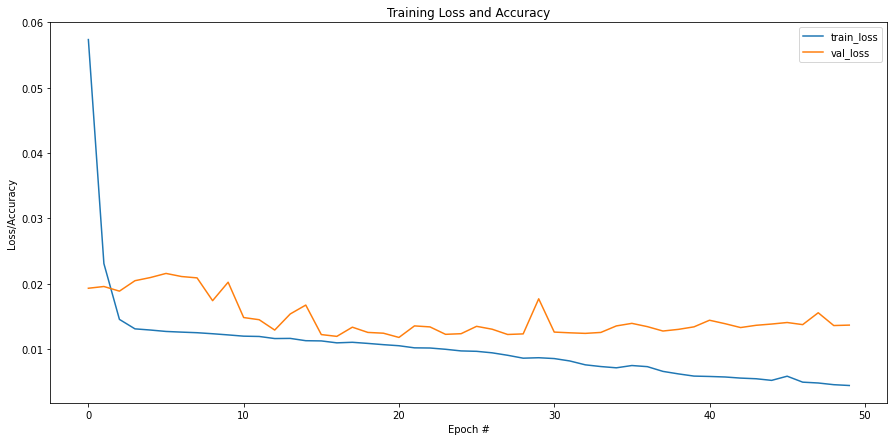

In [ ]:
print("[INFO] making predictions...")
decoded = auto_encoder.predict(val_x)
vis = visualize_predictions(decoded, val_x)
image_example_path = "reconstruction"
cv2.imwrite(os.path.join(image_example_path,"recon_vis.png"), vis)
N = np.arange(0, EPOCHS)
plt.figure(figsize=(15,7))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
with open('training_1_200_subclass.json', 'w') as f:
    json.dump(H.history, f)

In [ ]:
auto_encoder.save('training_1_200_subclass.h5')